# Librerias

In [24]:
import pandas as pd
import numpy as np
import utils as ut
import matplotlib.pyplot as plt
import lightgbm as lgbm
import sklearn as sk
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

# Cargar datos

In [25]:
data = pd.read_csv("data/ARIA_cleaned/citas.csv", index_col="ScheduledActivitySer")
data = data.sort_values(by="ActualStartDate")

In [26]:
elim = ["Duration", "DefaultDuration", "ScheduledDuration",'StartDateTime',"ScheduledStartTime","ScheduledEndTime",
        "ActualStartDate","ActualEndDate"]
data2 = data.drop(columns = elim)

c_categ = ['ScheduledActivityCode', 'CityOrTownship', 'NStage', 'Technique', 'NoEditFlag_sch', 'NotificationPriorTimeFlag_sch', 'Site', 'NumberOfFractions_isNaN', 'InterfaceStamp', 'Intent', 'IsMorning', 'TechniqueSer', 'TStage', 'TumorSize_isNaN', 'SchedulableFlag', 'SimulationNeeded', 'DayOfWeek', 'NotificationPriorTime_a', 'SummaryStage', 'TreatmentIntentType', 'Sex', 'NotificationPriorTimeFlag_a', 'DiagnosisCode_sec', 'MStage', 'ActivityCategoryCode', 'NotificationPriorTime_sch', 'ObjectStatus_sec', 'Description', 'ResourceGroupSer', 'ActivityCode', 'FractionFrequency', 'ObjectStatus_planes', 'PlanNormMethod', 'ActualMachineSer', 'AssignableFlag', 'Status_pres', 'ClinicalStatus', 'PhaseType', 'PrimaryPTVSer_isNaN', 'SkinFlashMargin', 'PrescribedDose_isNaN', 'HistologyCode', 'DateOfBirth_isNaN', 'Status_rtpps', 'StartDelay_isNaN', 'CalcModelOptions', 'EquipmentSer', 'Bolus', 'AnchorActivityFlag', 'DiagnosisCode', 'DicomSeqNumber', 'NoEditFlag_cat', 'MultiFieldOptFlag', 'TreatmentOrientation', 'PatientStatus', 'Priority', 'Notes', 'EnergyModeSer']

c_categ = list(set(c_categ) - set(elim))

# Train/test

In [27]:
# Label encoder
le = sk.preprocessing.LabelEncoder()
for i in c_categ:
    data2.loc[:,i] = le.fit_transform( data2[i].astype(str) )

In [28]:
# data2 = data2[["DiagnosisCode","ActivityCode","ActivityCategoryCode","PrescribedDose","NoOfFractions","NumFields","DateOfBirth",
#               "Site","Bolus","ScheduledActivityCode","EnergyModeSer","ActualMachineSer","ActualDuration"]]

# c_categ = set.intersection(set(["DiagnosisCode","ActivityCode","ActivityCategoryCode","PrescribedDose","NoOfFractions","NumFields","DateOfBirth",
#               "Site","Bolus","ScheduledActivityCode","EnergyModeSer","ActualMachineSer","ActualDuration"]),set(c_categ))
# c_categ = list(c_categ)

In [30]:
def train_test(data, train_size, target, random=True):
    size = round(len(data)*train_size)
    if random:
        np.random.seed(1)
        i = np.random.choice(range(len(data)), size=size, replace=False)
        j = np.setdiff1d(range(len(data)), i)
    else:
        i = np.arange(size)
        j = np.setdiff1d(range(len(data)), i)
        
    y_tr = data[target].iloc[i]
    y_te = data[target].iloc[j]
    x_tr = data.iloc[i,:].drop(columns = target)
    x_te = data.iloc[j,:].drop(columns = target)

    return (x_tr, y_tr, x_te, y_te, i, j)
    

(x_tr, y_tr, x_te, y_te, i, j) = train_test(data2, 0.7, "ActualDuration", False)
# (x_tr, y_tr, x_te, y_te, i, j) = train_test(data2, 0.7, "ScheduledDuration")
# (x_tr, y_tr, x_te, y_te, i, j) = train_test(data2, 0.7, "DefaultDuration")
print(len(x_tr))
print(len(x_te))

53817
23064


In [31]:
train = lgbm.Dataset(x_tr, label = y_tr, categorical_feature = c_categ )
test  = lgbm.Dataset(x_te, label = y_te, categorical_feature = c_categ )

In [32]:
parameters = {
    'objective': 'regression',
    'metric': ['rmse'],
#     'metric': ['poisson'],
    'boosting': 'gbdt',
    'learning_rate': 0.05,
    'verbose': 1,
#     'force_col_wise': 'true',
    
    # params util to prevent overfitting:
#     'feature_fraction': 0.25,
#     'bagging_fraction': 0.25,
#     'bagging_freq': 4,
    'num_leaves': 60,
#     'path_smooth': 10,
#     'lambda_l1': 100,
#     'lambda_l2': 100,
#     'min_data_in_leaf': 50,
#     'max_depth': 10,
    
#     'max_bin': 255,
#     'min_data_in_bin': 3,
}

model = lgbm.train(parameters, train, categorical_feature = c_categ, 
                       valid_sets = [test, ],
                       num_boost_round = 5000,
                       early_stopping_rounds = 200,
                  )
# 4.28

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006764 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1618
[LightGBM] [Info] Number of data points in the train set: 53817, number of used features: 67
[LightGBM] [Info] Start training from score 15.760768
[1]	valid_0's rmse: 10.0316
Training until validation scores don't improve for 200 rounds
[2]	valid_0's rmse: 9.74945
[3]	valid_0's rmse: 9.51997
[4]	valid_0's rmse: 9.27977
[5]	valid_0's rmse: 9.05446
[6]	valid_0's rmse: 8.87305
[7]	valid_0's rmse: 8.68354
[8]	valid_0's rmse: 8.51601
[9]	valid_0's rmse: 8.35483
[10]	valid_0's rmse: 8.21057
[11]	valid_0's rmse: 8.0747
[12]	valid_0's rmse: 7.95671
[13]	valid_0's rmse: 7.8515
[14]	valid_0's rmse: 7.75339

D:\miniconda3\envs\tfm2\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
D:\miniconda3\envs\tfm2\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))



[15]	valid_0's rmse: 7.65744
[16]	valid_0's rmse: 7.56998
[17]	valid_0's rmse: 7.49414
[18]	valid_0's rmse: 7.42131
[19]	valid_0's rmse: 7.34979
[20]	valid_0's rmse: 7.28886
[21]	valid_0's rmse: 7.23823
[22]	valid_0's rmse: 7.18701
[23]	valid_0's rmse: 7.13706
[24]	valid_0's rmse: 7.09367
[25]	valid_0's rmse: 7.05314
[26]	valid_0's rmse: 7.0145
[27]	valid_0's rmse: 6.9838
[28]	valid_0's rmse: 6.94908
[29]	valid_0's rmse: 6.91666
[30]	valid_0's rmse: 6.88998
[31]	valid_0's rmse: 6.86498
[32]	valid_0's rmse: 6.84087
[33]	valid_0's rmse: 6.82195
[34]	valid_0's rmse: 6.80317
[35]	valid_0's rmse: 6.785
[36]	valid_0's rmse: 6.7709
[37]	valid_0's rmse: 6.75501
[38]	valid_0's rmse: 6.74383
[39]	valid_0's rmse: 6.73401
[40]	valid_0's rmse: 6.71672
[41]	valid_0's rmse: 6.70556
[42]	valid_0's rmse: 6.69959
[43]	valid_0's rmse: 6.68663
[44]	valid_0's rmse: 6.67291
[45]	valid_0's rmse: 6.6639
[46]	valid_0's rmse: 6.65395
[47]	valid_0's rmse: 6.64415
[48]	valid_0's rmse: 6.6387
[49]	valid_0's rmse:

(0.8043045225979827, 0.0)
5.8658303175647495


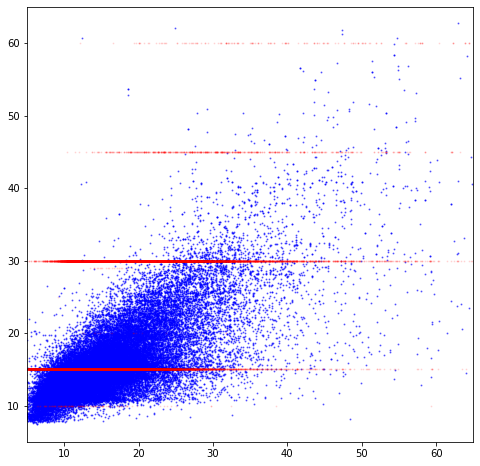

In [33]:
y_pred = model.predict(x_tr)
print(pearsonr(y_tr, y_pred))
print( mean_squared_error(y_tr, y_pred, squared=False) )

fig = plt.figure(1, figsize=(8,8))
plt.scatter(y_tr, y_pred, s = 1, alpha = 0.5, color = "blue")
plt.scatter(y_tr, data.ScheduledDuration.iloc[i], s = 1, alpha = 0.1, color = "red")

plt.xlim(5, 65)
plt.ylim(5, 65)
plt.show()

(0.7708863352071365, 0.0)
6.592640074396736


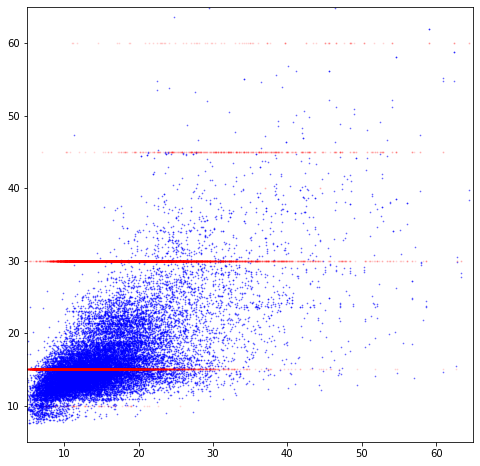

In [34]:
y_pred = model.predict(x_te)
print(pearsonr(y_te, y_pred))
print( mean_squared_error(y_te, y_pred, squared=False) )

fig = plt.figure(1, figsize=(8,8))
plt.scatter(y_te, y_pred, s=0.5, alpha = 0.5, color="blue")
plt.scatter(y_te, data.ScheduledDuration.iloc[j], s=1, alpha = 0.1, color="red")

plt.xlim(5, 65)
plt.ylim(5, 65)
plt.show()

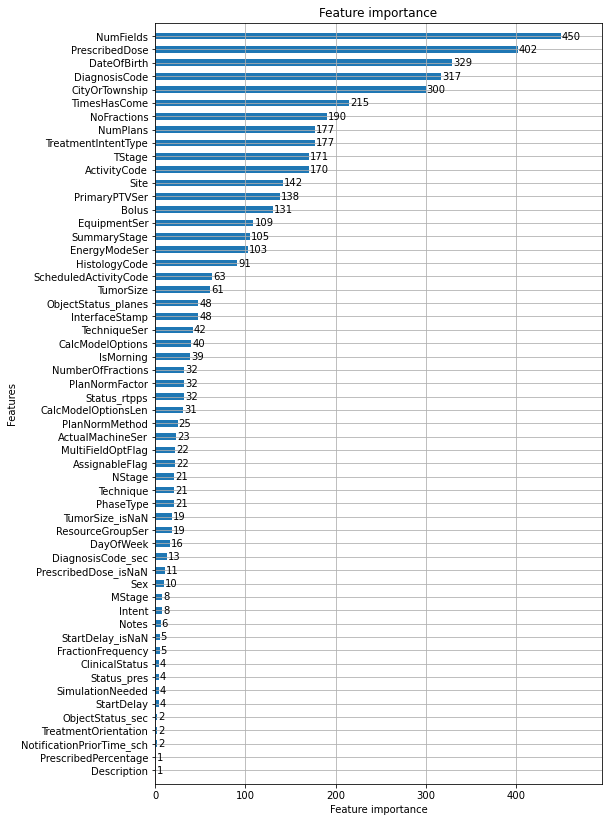

In [35]:
lgbm.plot_importance(model, height=0.5).figure.set_size_inches(8, 14)

<AxesSubplot:>

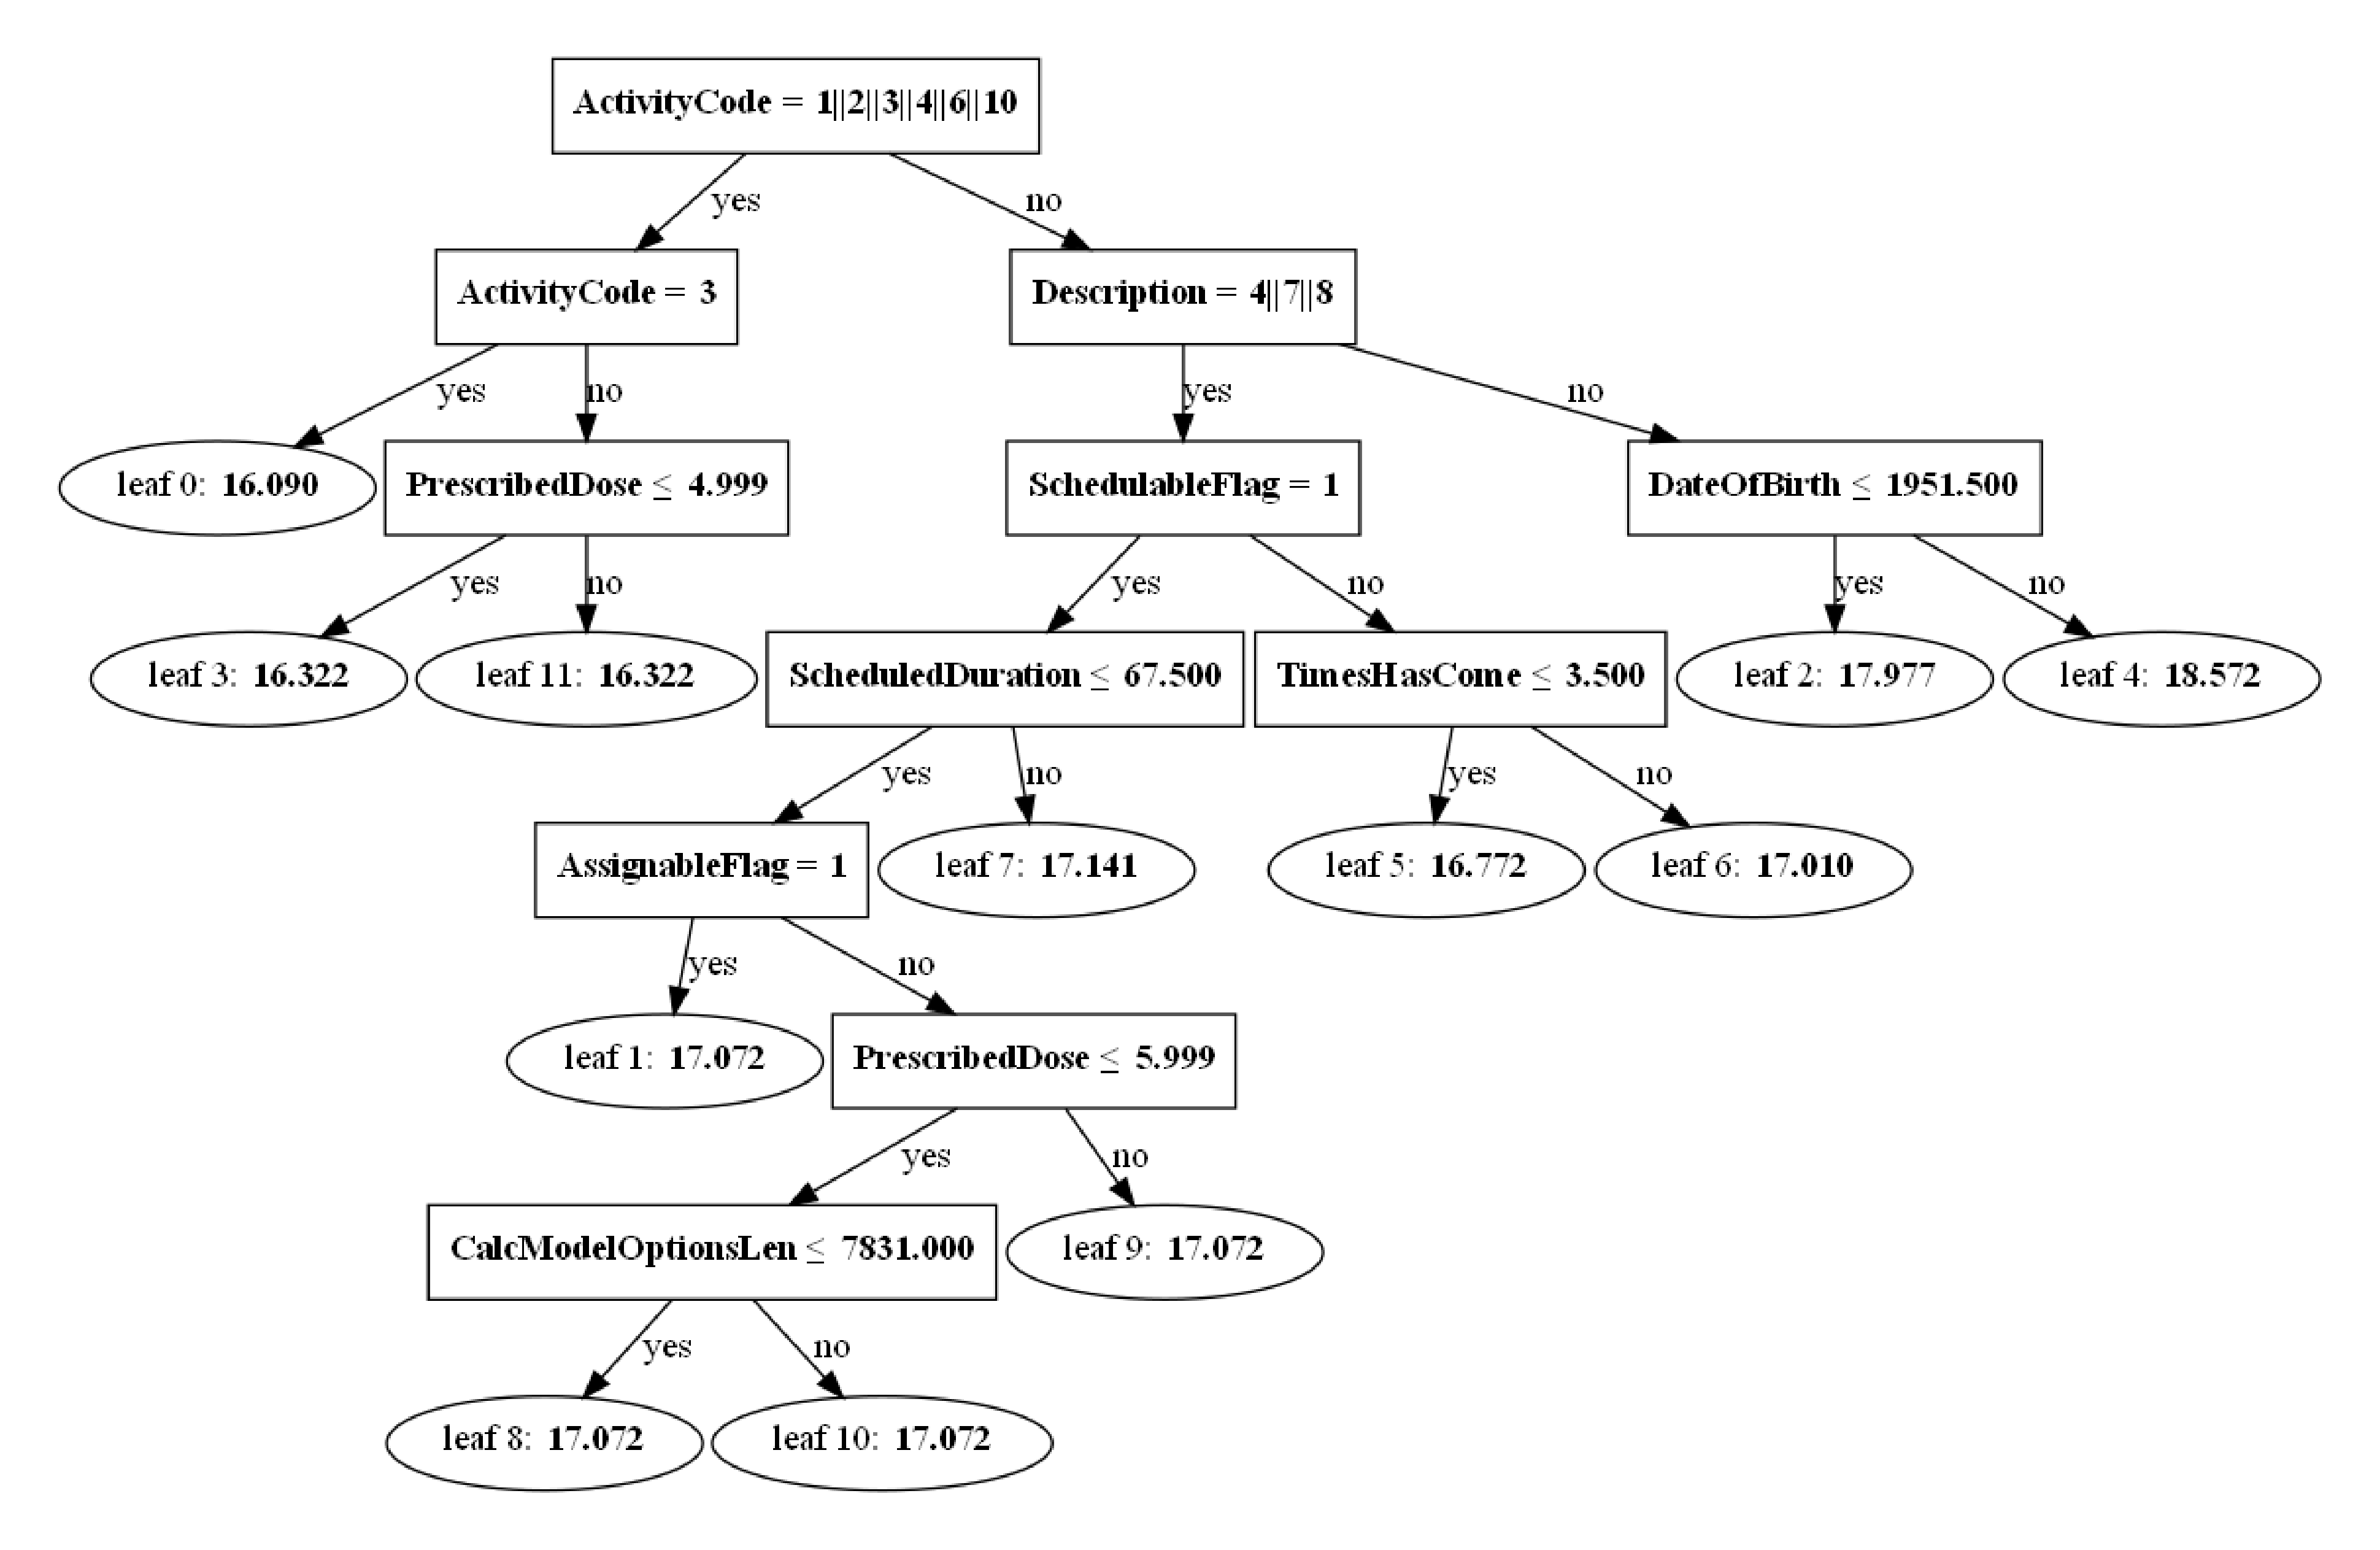

In [23]:
lgbm.plot_tree(model, tree_index = 0, orientation='vertical', dpi=800)

In [17]:
print(np.mean(y_pred))
print(np.mean(y_te))
print(np.mean(data.ScheduledDuration))

16.711259158007476
16.0908775580992
20.34986537636087


# Ex

In [ ]:
# uno = sch2.real[sch2.ActivityCode=="New Start"]
# dos = sch2.real[sch2.ActivityCode=="Fin Tratamiento"]
# tres= sch2.real
# # cua = sch2.real[sch2.ActivityCode=="Fin Tratamiento"]

# plt.hist(uno, bins=100, range=[0,40], density=True, alpha=0.5, color="red")
# plt.hist(dos, bins=100, range=[0,40], density=True, alpha=0.5, color="blue")
# plt.hist(tres,bins=100, range=[0,40], density=True, alpha=0.5, color="green")
# # plt.hist(cua ,bins=100, range=[0,40], density=True, alpha=0.5, color="yellow")
# plt.show()

# Linear regression

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression

c_num = list(set(data2.columns) - set(c_categ) - set(["ActualDuration"]))
c_num

enc = OneHotEncoder(handle_unknown='ignore')

i = c_categ
print(i)
X = enc.fit_transform( data2[i].astype(str) ).toarray()
X = np.concatenate([X, data2[c_num].values], axis=1)
y = data2.ActualDuration
X.shape

size = round(len(y)*0.7)
np.random.seed(1)
# i = np.random.choice(range(len(y)), size=size, replace=False)
i = np.arange(size)
j = np.setdiff1d(range(len(y)), i)
        
X_tr = X[i,:]
y_tr = y.iloc[i]        
X_te = X[j,:]
y_te = y.iloc[j]

reg = LinearRegression().fit(X_tr, y_tr)

y_pred = reg.predict( X_tr )
print(pearsonr(y_tr, y_pred))
print( mean_squared_error(y_tr, y_pred, squared=False) )

plt.hist((y_tr-y_pred), bins=100)
plt.show()

y_pred = reg.predict( X_te )

print(pearsonr(y_te, y_pred))
print( mean_squared_error(y_te, y_pred, squared=False) )

plt.hist((y_te-y_pred), bins=100, range=[-50,50])
plt.show()

fig = plt.figure(1, figsize=(8,8))
plt.scatter(y_te, y_pred, s = 1, alpha = 0.5, color = "blue")
plt.scatter(y_te, data.ScheduledDuration.iloc[j], s = 1, alpha = 0.1, color = "red")

plt.xlim(5, 65)
plt.ylim(5, 65)
plt.show()